In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline
import time
import glob
import matplotlib

from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from binance.client import Client
import random

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
weight_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/price_model/'
label_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/label_model/'

primary = load(label_path+'primary_model.joblib') 
secondary = load(label_path+'secondary_model.joblib')

In [5]:
model_dict = {}

all_files = glob.glob(weight_path + "/*.pth")

for file in all_files:
    
    model = torch.load(file)
    model_dict[file.split('\\')[1][1:-4]] = model

In [6]:
list(model_dict.keys())

['ADA',
 'BNB',
 'ETH',
 'LINK',
 'LTC',
 'normalized_ADA',
 'normalized_BNB',
 'normalized_ETH',
 'normalized_LINK',
 'normalized_LTC',
 'normalized_XRP',
 'XRP']

In [7]:
coin_list=['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']

In [8]:
df_dict = {}

directory = '../data/final_data' ### directory with final data
all_files = glob.glob(directory + "/*.csv")

for file in all_files:
    
    df = pd.read_csv(file, index_col=None, header=0)
    df_dict[file.split('\\')[1][:-10]] = df

In [9]:
columns = list(df_dict[coin_list[0]].columns)
not_quant = ['Open Time','Close Time', 'bin'] ### take out label and non-quantitative data 
quants = [i for i in columns if i not in not_quant][1:]

In [10]:
import nbimporter
from src import models
from src import retrieve_keys
keys = retrieve_keys.Keys()
api, secret=keys.ret_keys()

Importing Jupyter notebook from C:\Users\Justin\Desktop\currentworks\bot\Justin's Files\src\models.ipynb
Importing Jupyter notebook from C:\Users\Justin\Desktop\currentworks\bot\Justin's Files\src\retrieve_keys.ipynb


In [11]:
lstm_params=torch.load('E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/parameters/price_lstm.params')

In [12]:
input_dim=int(lstm_params[0])
hidden_dim=int(lstm_params[1])
n_layers=int(lstm_params[2])
output_dim=int(lstm_params[3])

In [13]:
price_model = models.LSTM(input_dim, hidden_dim, n_layers, output_dim)

In [14]:
## example with ETH 

In [15]:
price_model.load_state_dict(model_dict['ETH'])

<All keys matched successfully>

In [16]:
example_data=df_dict['ETH']

In [17]:
example_data.head()

,Unnamed: 0,Open Time,Time of Day,Open,High,Low,Close,Volume,Close Time,Quote asset vol,...,fastd,SAR,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,Spinning Top
0,174,2017-07-17 19:00:00,68400,0.084001,0.084948,0.083803,0.084401,148.592,2017-07-17 19:29:59.999,12.518292,...,21.861277,0.093699,48.706954,-63.613793,-338.080216,-25.036520,2286.077,0.001426,0.001426,0.0
1,175,2017-07-17 19:30:00,70200,0.084543,0.084806,0.083997,0.084530,138.855,2017-07-17 19:59:59.999,11.721327,...,32.486400,0.093699,47.095021,-60.055172,-293.969295,-10.497259,2424.932,0.001382,0.001382,-1.0
2,176,2017-07-17 20:00:00,72000,0.084527,0.085682,0.084257,0.085385,145.361,2017-07-17 20:29:59.999,12.345477,...,65.819734,0.093699,50.203023,-36.468966,-209.200880,23.376685,2570.293,0.001385,0.001385,0.0
3,177,2017-07-17 20:30:00,73800,0.085632,0.087345,0.085378,0.086139,152.328,2017-07-17 20:59:59.999,13.179450,...,85.743719,0.093699,53.760233,-29.371651,-243.662476,24.144001,2722.621,0.001427,0.001427,0.0
4,178,2017-07-17 21:00:00,75600,0.086357,0.087203,0.086234,0.086626,110.859,2017-07-17 21:29:59.999,9.613967,...,100.000000,0.093699,49.002871,-20.066983,-264.827507,15.528666,2833.480,0.001401,0.001401,0.0


In [18]:
from src import create_sequences

Importing Jupyter notebook from C:\Users\Justin\Desktop\currentworks\bot\Justin's Files\src\create_sequences.ipynb


In [19]:
sequences=create_sequences.Create_Sequences(example_data, 24)

In [20]:
sequences=sequences.sequences

In [21]:
sequences.shape

torch.Size([58181, 24])

In [77]:
sample_size=1000

In [78]:
index=random.randint(0, example_data.shape[0]-sample_size)
data_sample=example_data[quants].iloc[index:index+sample_size]
sample_sequence=sequences[index-23:index-23+sample_size].reshape(sample_size, 24, 1)

In [79]:
primary_results=primary.predict(np.array(data_sample))
secondary_results=secondary.predict(np.array(data_sample))
probabilities=secondary.predict_proba(np.array(data_sample))
similar=np.equal(primary_results, secondary_results)

In [80]:
np.unique(primary_results, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([274, 246, 480], dtype=int64))

In [81]:
with torch.no_grad():
    price_predictions=price_model(sample_sequence.float())

In [84]:
price_labels=[0]
for i in range(1, sample_size):
    if price_predictions[i] > data_sample['Close'].values[i] and data_sample['Close'].values[i - 1] > data_sample['Close'].values[i]:
        price_labels.append(1)
    elif price_predictions[i] < data_sample['Close'].values[i] and data_sample['Close'].values[i - 1] < data_sample['Close'].values[i]:
        price_labels.append(-1)
    else:
        price_labels.append(0)

In [85]:
np.unique(np.array(price_labels), return_counts=True)

(array([-1,  0,  1]), array([ 48, 482, 470], dtype=int64))

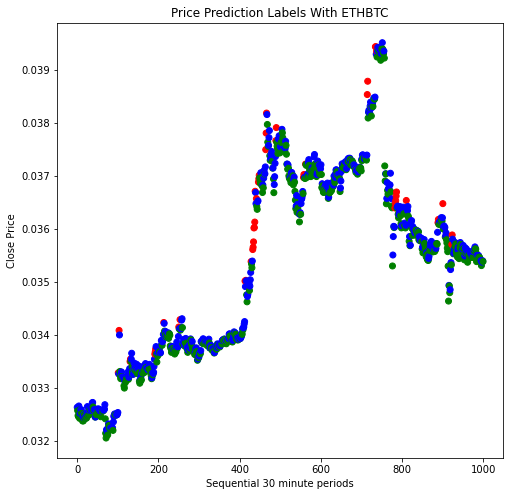

In [114]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(range(1000), data_sample['Close'].values, c=price_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Price Prediction Labels With ETHBTC')
plt.xlabel('Sequential 30 minute periods')
plt.ylabel('Close Price')

plt.show()

In [113]:
cumulative_results=[]
for i in range(1000):
    if similar2[i]==True:
        cumulative_results.append(primary_results[i])
    else:
        cumulative_results.append(0)

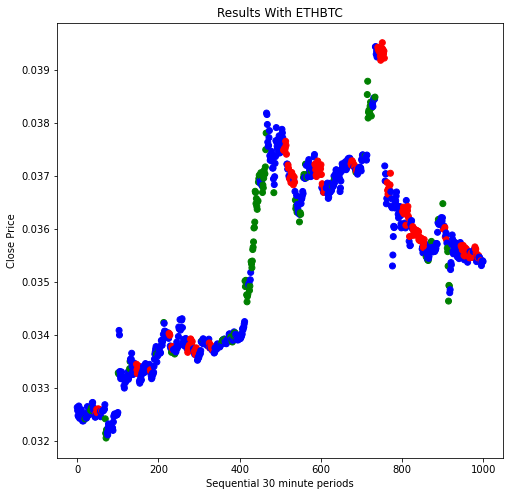

In [115]:
colors=['red', 'blue', 'green']
fig = plt.figure(figsize=(8,8))
plt.scatter(range(1000), data_sample['Close'].values, c=cumulative_results, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Results With ETHBTC')
plt.xlabel('Sequential 30 minute periods')
plt.ylabel('Close Price')

plt.show()

In [87]:
difference_volumes1=[]
volumes1=[]
for i in range(sample_size):
    if similar[i]==True and primary_results[i] in [1, -1]:
        mid=np.max(probabilities[i])-np.min(probabilities[i])
        volumes1.append(np.max(probabilities[i]))
        if np.max(probabilities[i])-mid > .2:
            difference_volumes1.append((np.max(probabilities[i])-mid)/(1-mid))
        else:
            difference_volumes1.append(0)
    else:
        difference_volumes1.append(0)
        volumes1.append(0)

In [92]:
similar2=np.equal(primary_results, secondary_results, np.array(price_labels))

In [99]:
np.unique(similar2, return_counts=True)

(array([0, 1]), array([636, 364], dtype=int64))

In [103]:
difference_volumes2=[]
volumes2=[]

for i in range(sample_size):
    if similar2[i]==True and primary_results[i] in [1, -1]:
        if primary_results[i]==-1:
            mid=np.max(probabilities[i])-np.min(probabilities[i])
            volumes2.append(-np.max(probabilities[i]))
            if np.max(probabilities[i])-mid > .2:
                difference_volumes2.append(-(np.max(probabilities[i])-mid)/(1-mid))
            else:
                difference_volumes2.append(0)
                
        elif primary_results[i]==1:
            mid=np.max(probabilities[i])-np.min(probabilities[i])
            volumes2.append(np.max(probabilities[i]))
            if np.max(probabilities[i])-mid > .2:
                difference_volumes2.append((np.max(probabilities[i])-mid)/(1-mid))
            else:
                difference_volumes2.append(0)
    else:
        difference_volumes2.append(0)
        volumes2.append(0)
        

In [104]:
volumes2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.44,
 0,
 0.47,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.41,
 0.49,
 0.42,
 0.41,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.42,
 0,
 -0.5,
 -0.4,
 -0.63,
 -0.52,
 -0.56,
 -0.57,
 -0.54,
 -0.52,
 -0.43,
 0,
 0,
 0,
 -0.47,
 -0.55,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.43,
 0.47,
 0.53,
 0.51,
 0.46,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.46,
 0.43,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.41,
 0.47,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.51,
 -0.53,
 -0.43,
 -0.52,
 -0.47,
 -0.55,
 -0.55,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.49,
 -0.44,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.49,
 0,
 0.44,
 0,
 0,
 0.43,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.53,
 0,
 